# Twitter Named Entity Recognition

## Problem Statement

Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.

Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

Named Entity Recognition (NER) is an important subtask of information extraction that seeks to locate and recognise named entities.

You need to train models that will be able to identify the various named entities.

## Data Description

Dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product,music artist, movie, sports team, tv show and other. Dataset was extracted from tweets and is structured in CoNLL format., in English language. Containing in Text file format.

# Solution approach

In this notebook, I finetune bert-base-cased model to solve NER problem for the given set of 6000 tweets. The tweets and named entities are provided in Conll format where each line contains a word and its BIO tag. The end of the sentence is represented with a blank line. There are total 21 BIO classes: B and I pair for 10 named entities and an 'O' class.

**Overall architecture: **

The sentences are padded to 39 words. The data are converted to the format required for BERT model (token_ids, sentence_token_ids, and attention_mask). The Bert encoder output is then fed into a couple of dense layers with drop out layers added in-between. CategorocalFocalLoss function is used for training with learning rate 3e-5, clipnorm 1.0, dropout rate 0.3, gamma 2, label-smoothing 0.1, and custom weights for alpha parameter.

**Data imbalance**: The data is highly imbalanced with 'O' tag constituting around 92% of the words. To alleviate the data imbalance issue, I implementd the following measures.

  1. Undersampled majority class 'O' by removing 80% of the all-'O' statements. Over-sampled each entity class to ensure there are minimum 1000 examples of each class in the training set. With this the data imbalanced improved somewhat.  
  2. I used CategoricalFocalCrossEntropy function as a loss function which works better than plain CategoricalCrossEntropy function when the classes are highly imbalanced. I tuned Gamma(5), label-smoothing(0.15) and alpha (class weights) parameters to obtained better results.

**Custom metric**: I use Seqeval's f1 score as the primary evaluation metric which is suited for NER task evaluation. I also compute custom metrics such as balanced_accuracy (since the dataset is highly imbalanced, I avoid using accuracy) and weighted f1 score for entity classes (ignoring the majority 'O' class). The above metrics are implemented as Keras custom metrics so that they can be computed during the training loop. During evaluation, I compute both class level metrics (precision, recall, and standard F1 scores) as well as overall metrics (seqeval f1 score, balanced_accuracy, and weighted precision, recall, and F1 scores after ignoring the majority negative class 'O').



# Solution

## Common installs and setup

In [1]:
#mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [3]:
#evaluation metric
!pip install seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 933.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
#mlflow for experiment tracking
!pip install mlflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.6 MB/s eta 0:00:00


In [5]:
#Common imports and constants
import numpy as np
import pandas as pd
import os.path
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter, defaultdict
import os

import tensorflow as tf
from keras.layers import TextVectorization, Embedding
from keras.utils import pad_sequences, to_categorical

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

import mlflow

CONST = {
  'TRAIN_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut 16.txt.conll',
  'DEV_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut16_dev.conll',
  'TEST_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut 16test.txt.conll',
  'SAVED_MODEL': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/saved_model/bert/',

  'SAVED_EMBEDDINGS_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/bert_embeddings/',
  'MLRUNS_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/mlruns/',
  'MLFLOW_NER_EXPERIMENT_NAME' : 'mlflow_bert_exp',
  'MODEL_CHECKPOINT_FILE_PATH' : '/content/bert-checkpoints/'
}

DATA_PARAMS = {
  'preserve_case': True,
  'bert_model': 'bert-base-cased',
  'MAX_TOKEN_SEQ_LENGTH': 128,
  'clean-url': True,
  'remove-special-chars': True,
  'all-o-keep-rate': 0.2,
  'oversample-min-cnt': 1000
}

#set random seed

def set_seeds(seed=123):
  os.environ['PYTHONHASHSEED']=str(seed)
  np.random.seed(1)
  tf.random.set_seed(seed)
  random.seed(seed)

set_seeds()

In [6]:
#create necessary directory structure locally and or on the mounted drive
if not os.path.exists(CONST['SAVED_EMBEDDINGS_PATH']):
    os.makedirs(CONST['SAVED_EMBEDDINGS_PATH'])

if not os.path.exists(CONST['MLRUNS_PATH']):
    os.makedirs(CONST['MLRUNS_PATH'])

if not os.path.exists(CONST['MODEL_CHECKPOINT_FILE_PATH']):
    os.makedirs(CONST['MODEL_CHECKPOINT_FILE_PATH'])

In [7]:
# get or create crf experiment
mlflow.set_tracking_uri(f"file://{CONST['MLRUNS_PATH']}")

crf_exp_name = CONST['MLFLOW_NER_EXPERIMENT_NAME']
crf_exp = mlflow.get_experiment_by_name(crf_exp_name)
if(not crf_exp):
  crf_exp_id = mlflow.create_experiment(crf_exp_name)
else:
  crf_exp_id = crf_exp.experiment_id
print(crf_exp_id)


898272108374470700


In [8]:
#mlflow log
import json

class mlflow_logger:
  def __init__(self, mlflow):
    self.mlflow = mlflow

  def log_obj(self, obj):
    for k, v in obj.items():
      self.mlflow.log_param(k, v)

  def log_metric(self, k, v):
    mlflow.log_metric(k, v)

  def log_df_metrics(self, df):
    acc = df.loc[('-', 'accuracy', 'all (BIO)')][0]
    f1 = df.loc[('weighted', 'f1', 'all (BIO)')][0]
    f1_without_o = df.loc[('weighted', 'f1', 'only BI')][0]

    mlflow.log_metric('acc', acc)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('f1-without-o', f1_without_o)


In [9]:
#!rm -r '/content/mlruns'

## Load Data

In [10]:
# helper function to load conll file
def load_conll2(files, data_proc_fn=None):
  files = [files] if (type(files) == str) else files

  preserve_case = DATA_PARAMS['preserve_case']
  sentences = []
  words, tags = [], []
  parse_err_cnt = 0

  for file in files:
    with open(file, "r") as f:

      while True:
        s = f.readline()
        if len(s) == 0: #end of file
          break

        s = s.strip()

        if not s: #end of sentence
          sentences.append((words, tags))
          words, tags = [], []
        else:
          #used defined pre-processing
          if(data_proc_fn):
            s = data_proc_fn(s)

          #parse
          try:
            word, tag = s.replace('\n', '').split('\t')

            word = word.strip()
            if(preserve_case == False):
              word = word.lower()

            words.append(word) #converted to lower case
            tags.append(tag)

          except Exception as e:
            parse_err_cnt += 1
            print(f'error parsing {s}', e)
            break

      if(parse_err_cnt > 0):
        print(f'total parsing errors: {parse_err_cnt}')

  return sentences

def compute_data_objects(data):
  wordctr, tagctr = Counter(),Counter()
  word_tag_map, tag_word_map = defaultdict(), defaultdict()

  for i in range(len(data)):
    words_arr, tags_arr = data[i][0], data[i][1]
    wordctr.update(words_arr)
    tagctr.update(tags_arr)

    for j in range(len(words_arr)):
      word, tag = words_arr[j], tags_arr[j]

      #extract named entity name
      ne = tag.replace('B-', '').replace('I-', '')

      #add to word_tag_map
      if word not in word_tag_map.keys():
        word_tag_map[word] = set([ne])
      else:
        word_tag_map[word].add(ne)

      #add to tag_word_map
      if ne not in tag_word_map.keys():
        tag_word_map[ne] = set([word])
      else:
        tag_word_map[ne].add(word)

  return wordctr, tagctr, word_tag_map, tag_word_map

In [11]:
# #merge train and test data
# merged_data = load_conll2([CONST['TRAIN_DATA_PATH'], CONST['DEV_DATA_PATH']])

# #split merged data into train and dev sets
# train_data, dev_data = train_test_split(merged_data, test_size=0.3, random_state=42, shuffle=True)
# #load test dataset
# test_data = load_conll2([CONST['TEST_DATA_PATH']])

In [12]:
#merge train, dev and test data
merged_data = load_conll2([CONST['TRAIN_DATA_PATH'], CONST['DEV_DATA_PATH'], CONST['TEST_DATA_PATH']])

#split merged data into train and test sets
train_data, test_data = train_test_split(merged_data, test_size=0.25, random_state=42, shuffle=True)
train_data, dev_data = train_test_split(train_data, test_size=0.3, random_state=42, shuffle=True)

len(train_data), len(dev_data), len(test_data)

(3801, 1630, 1811)

In [13]:
#compute useful data objects
train_wordset, train_tagset, train_word_tag_map, train_tag_word_map = compute_data_objects(train_data)
test_wordset, test_tagset, test_word_tag_map, test_tag_word_map = compute_data_objects(test_data)
dev_wordset, dev_tagset, dev_word_tag_map, dev_tag_word_map = compute_data_objects(dev_data)

In [14]:
def get_sentences_and_tags(data):
  sentences = [words for words, tags in data]
  tags = [tags for words, tags in data]

  return sentences, tags

train_sentences, train_tags = get_sentences_and_tags(train_data)
test_sentences, test_tags = get_sentences_and_tags(test_data)
dev_sentences, dev_tags = get_sentences_and_tags(dev_data)

## Data Exploration

In [15]:
def get_tags_count_df(tags_list):
  tag_freq_dist = pd.Series(np.hstack(tags_list)).value_counts()
  df = pd.DataFrame(tag_freq_dist, columns=['freq'])
  df['perc'] = np.round((df['freq'] / np.sum(df['freq'])) * 100, 3)
  return df

## Data cleaning

In [16]:
#replace URLs with <URL> to avoid creating several vocabulary words unnecessarily
import re

url_pattern = re.compile(r'https?://(www.)?([^/?]*)(\S*)|www.([^/?]*)(\S*)',re.IGNORECASE)

def sanitize_sentences(sentences, clean_url=True, remove_special_char=True):

  cnt_url, cnt_sc = 0, 0

  if(not clean_url and not remove_special_char):
    return cnt_url, cnt_sc

  for i, s in enumerate(sentences):
    for j in range(len(s)):

      if(clean_url):

        res = re.match(url_pattern, s[j])
        if(res):
          s[j] = res.groups()[1] or res.groups()[3] or s[j]
          cnt_url += 1
          continue

      if(remove_special_char):
        newval = ''.join(e for e in s[j] if e.isalnum())
        if(newval != s[j]):
          s[j] = newval or '#'
          cnt_sc += 1

  return cnt_url, cnt_sc

clean_url_flag, remove_sp_char_flag = DATA_PARAMS['clean-url'], DATA_PARAMS['remove-special-chars']

tr_urls_cleaned, tr_special_char_removed = sanitize_sentences(train_sentences, clean_url_flag , remove_sp_char_flag)
dv_urls_cleaned, dv_special_char_removed = sanitize_sentences(dev_sentences, clean_url_flag, remove_sp_char_flag)
te_urls_cleaned, te_special_char_removed = sanitize_sentences(test_sentences, clean_url_flag, remove_sp_char_flag)

print(f'Train: url_cleaned: {tr_urls_cleaned}, special_chars removed: {tr_special_char_removed}')
print(f'Test: url_cleaned: {te_urls_cleaned}, special_chars removed: {te_special_char_removed}')
print(f'dev: url_cleaned: {dv_urls_cleaned}, special_chars removed: {dv_special_char_removed}')

Train: url_cleaned: 1759, special_chars removed: 14783
Test: url_cleaned: 786, special_chars removed: 6948
dev: url_cleaned: 740, special_chars removed: 6353


## Data Rebalancing

In [17]:
def get_drop_all_O_candidates(tags, keep_rate=1.0):
  drop_rate = 1 - keep_rate

  #prepare mask for all_O sentences. True if it's an all_O sentence, False otherwise
  mask = pd.Series([len(s) == np.sum(np.array(s) == 'O') for s in tags])

  total_candidates = np.sum(mask)

  #select drop_rate percent of sentences to drop
  drop_candidates = mask[mask == True].sample(int(drop_rate * total_candidates)).index.values

  return drop_candidates

def drop_all_O_sentences(keep_rate, tags, *arrlist):

  ret = []

  drop_candidates = get_drop_all_O_candidates(tags, keep_rate)

  if(len(drop_candidates) > 0):

    for arr in arrlist:

      ret_arr = np.array(arr, dtype=object)
      ret_arr = np.delete(ret_arr, drop_candidates).tolist()
      ret.append(ret_arr)

  print(f'number of all-o sentences removed: {len(drop_candidates)}')

  return ret


#remove all_O sentences
train_sentences, train_tags = drop_all_O_sentences(DATA_PARAMS['all-o-keep-rate'], train_tags, train_sentences, train_tags)

print('\nTag count distribution for training dat after removing all_O sentences\n')
print(get_tags_count_df(train_tags))

number of all-o sentences removed: 1626

Tag count distribution for training dat after removing all_O sentences

Empty DataFrame
Columns: [freq, perc]
Index: []


In [18]:
# rebalance tags

def oversample(sentences, tags, taglist, min_count=500):

  def get_cnt_of(sent, tag_name):
    return np.count_nonzero(sent == tag_name)

  #initialize tag to sentence index mapping
  tag_sentence_map = {t:[] for t in taglist}

  for i, s in enumerate(tags):
    tags_arr = pd.Series(s)
    vc = tags_arr.value_counts()
    for tag in vc.index:
      tag_sentence_map[tag].append((i, vc[tag]))


  #tag counts
  tag_counts = {}
  for t, arr in tag_sentence_map.items():
    tag_counts[t] = np.sum([pair[1] for pair in arr])

  ordered_tags = sorted(tag_counts.items(), key=lambda x: x[1])

  indices_to_add = []

  for tag, cnt in ordered_tags:
    #print('processing tag', tag)
    if(cnt > min_count):
      break

    while(True):
      deficit = min_count - tag_counts[tag]
      #print(f'decific for tag {tag} is {deficit}')
      if(deficit > 0):
        sent_indices = tag_sentence_map[tag]
        index1 = np.random.randint(low=0, high=len(sent_indices))
        index2, cnt2 = sent_indices[index1]

        indices_to_add.append(index2)

        #update count of all tags included in that sentence
        tags_arr = pd.Series(tags[index2])
        vc = tags_arr.value_counts()
        for t in vc.index:
          tag_counts[t] += vc[t]

      else:
        #print(f'breaking for {tag}, deficit is {deficit}')
        break

  return indices_to_add

In [19]:
indices_to_add = oversample(train_sentences, train_tags, list(train_tagset.keys()), min_count=DATA_PARAMS['oversample-min-cnt'])
print('indeces to add', len(indices_to_add))
for i in indices_to_add:
  train_sentences.append(list(train_sentences[i]))
  train_tags.append(list(train_tags[i]))

indeces to add 5238


In [20]:
print('\nTag count distribution after rebalancing\n')
print(get_tags_count_df(train_tags))


Tag count distribution after rebalancing

Empty DataFrame
Columns: [freq, perc]
Index: []


## Data preparation

In [21]:
# load transformers tokenizer
from transformers import BertTokenizer, TFBertForTokenClassification

#create tokenizer
bert_model = DATA_PARAMS['bert_model']
preserve_case = DATA_PARAMS['preserve_case']

tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=(not preserve_case))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
#create tag map
tags = list(train_tagset.keys())
tags.remove('O')
tags = sorted(tags, key=lambda x: x[::-1])
tags.insert(0, 'O')

tagsmap = {t:i  for i, t in enumerate(tags)}
n_tags = len(tags)

In [23]:
from collections import defaultdict

#utility class to transform input and output
class BertHelper:

  def __init__(self, seqlen, tagsmap, tokenizer):
    self.seqlen = seqlen #padded length of input sequence
    self.tagsmap = tagsmap #class str to int mapping
    self.tokenizer = tokenizer
    self.special_ids = self.tokenizer.all_special_ids

  def getsubtokentag(self, index, tag):
    # if(tag.startswith('B-')): #this token belongs to the beginning word of an entity
    #     if(index > 0): #except for the very first token, rest should be converted from 'B-XX' to 'I-XX'
    #       return tag.replace('B-', 'I-')

    return tag

  def prepareinput(self, sentences, tags):

    ret_tokens = []
    ret_token_tags = []
    ret_token_ids = []
    ret_token_tag_ids = []
    ret_token_type_ids = []
    ret_attention_mask = []
    ret_word_token_cnt = []

    #process each sentence
    #for words, words_orig_case, tags in sentences:
    for words, tags in zip(sentences, tags):
      ti = 0 #token index

      tokens = []
      token_tags = []
      word_token_cnt = []

      token_ids = np.zeros(shape=self.seqlen, dtype=int)
      token_tag_ids = np.ones(shape=self.seqlen, dtype=int) * -1 #we use -1 to differentiate <pad> tokens from the valid tag classes
      token_type_ids = np.zeros(shape=self.seqlen, dtype=int)
      attention_mask = np.zeros(shape=self.seqlen, dtype=int)

      #process each word in the sentence
      for i in range(len(words)):
        word, tag = words[i], tags[i]
        tok_arr = tokenizer.tokenize(word) #tokenize in sub-tokens
        tok_ids = tokenizer.convert_tokens_to_ids(tok_arr) #ids corresponding to sub-tokens
        tc = len(tok_arr)
        word_token_cnt.append(tc)

        #process jth subtoken of ith word
        for j in range(tc):

          if(ti+j >= self.seqlen):
            break

          token_tag_cls = self.getsubtokentag(j, tag)
          token_tag_id = self.tagsmap[token_tag_cls]

          tokens.append(tok_arr[j])
          token_tags.append(token_tag_cls)

          token_ids[ti + j] = tok_ids[j]
          token_tag_ids[ti + j] = token_tag_id

          attention_mask[ti + j] = 1

        ti += tc
        if(ti >= self.seqlen):
          break

      ret_tokens.append(tokens)
      ret_token_tags.append(token_tags)
      ret_word_token_cnt.append(word_token_cnt)

      ret_token_ids.append(token_ids)
      ret_token_tag_ids.append(token_tag_ids)
      ret_token_type_ids.append(token_type_ids)
      ret_attention_mask.append(attention_mask)

    return ret_tokens, ret_token_tags, ret_word_token_cnt, np.array(ret_token_ids), np.array(ret_token_tag_ids), np.array(ret_token_type_ids), np.array(ret_attention_mask)

  #returns flattened word-level class labels(tags) given the original tags
  def getwordlabels(self, tags, return_tagids=False):
    return np.array([tagsmap[t] if (return_tagids) else t for tagarr in tags for t in tagarr])


  #returns flattened word level predictions from token level predictions after discarding padded elements.
  def getwordpredictions(self, word_token_cnt, pred_arr, return_tagids=False):

    y_pred = []
    o_tag = tagsmap['O']
    debug = {'tokenlen': defaultdict(lambda : 0), 'token_exceeded' : [], 'token_exceeded_indx': []}

    # iterate over each sentence
    for i in range(len(word_token_cnt)):

      sent_word_token_cnt = word_token_cnt[i]
      token_pred_tags = pred_arr[i] #predicted tokens

      j = 0
      k = 0
      for j in range(len(sent_word_token_cnt)):
        token_cnt = sent_word_token_cnt[j]
        if(token_cnt == 0):
          continue

        word_token_pred_tags = token_pred_tags[k: k+token_cnt]

        pred_tag_id = word_token_pred_tags[0]
        #pred_tag_id = ([tag for tag in word_token_pred_tags if tag != 0] + [0])[0] #get the first non-O tag or O
        y_pred.append(pred_tag_id)

        k += token_cnt

        if(k >= len(token_pred_tags)):
          break

      if(j < len(sent_word_token_cnt)):

        #this means that total number of tokens for this sentence exceeded the maxseqlen.
        #to avoid alignment issue with y_actual, we add a dummy 'O' tags for the unprocessed words.

        while(j < len(sent_word_token_cnt)):
          #y_pred.append(o_tag)
          j += 1

        debug['token_exceeded_indx'].append(i)

    if(return_tagids == False):
      y_pred = [tags[tind] for tind in y_pred]

    return np.array(y_pred), debug

berthelper = BertHelper(DATA_PARAMS['MAX_TOKEN_SEQ_LENGTH'], tagsmap, tokenizer)

In [24]:
tokens_tr, token_tags_tr, word_token_cnt_tr, token_ids_tr, token_tag_ids_tr, token_type_ids_tr, attention_mask_tr = berthelper.prepareinput(train_sentences, train_tags)
tokens_te, token_tags_te, word_token_cnt_te, token_ids_te, token_tag_ids_te, token_type_ids_te, attention_mask_te = berthelper.prepareinput(test_sentences, test_tags)
tokens_dv, token_tags_dv, word_token_cnt_dv, token_ids_dv, token_tag_ids_dv, token_type_ids_dv, attention_mask_dv = berthelper.prepareinput(dev_sentences, dev_tags)

In [25]:
#quick sanity check. pass y_true as the y_pred, and we should get back the original word level tags
# y_pred1,_ = berthelper.getwordpredictions(word_token_cnt_tr, token_tag_ids_tr, return_tagids=True)
# y_actual1 = berthelper.getwordlabels(train_tags, return_tagids=True)

# sum(y_pred1 != y_actual1)

## Defining custom metrics

The training data consists of fixed size sequences with many padded tokens in each sentence. By default, keras compute metrics over all the elements of the sequence-including the padding elements. To rectify this, we create custom metrics which igore padded elements when computing metrics. Since out dataset is highly imbalanced, we also use balanced_accuracy as a reporting metric, in addition to using plain accuracy.

In [26]:
#simple metric which counts number of nonpadded elements seen so far (in each epoch)
class CustomTotal(tf.keras.metrics.Metric):
    def __init__(self, ignore_pad=True, name='custom_total', **kwargs):
        super(CustomTotal, self).__init__(name=name, **kwargs)

        self.ignore_pad = ignore_pad
        self.total = self.add_weight(name='total', initializer='zeros', dtype=np.int32)

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        if(self.ignore_pad):
          nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)
          total = tf.reduce_sum(tf.cast(nonpad_mask, tf.int32))
        else:
          total = tf.multiply(y_true_ohe.shape[0], y_true_ohe.shape[1])

        self.total.assign(self.total + total)

    def result(self):
        return self.total

    def reset_state(self):
        self.total.assign(0)

In [27]:
#mimicks accuracy metric, however ignores padded elements
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='acc', ignore_pad=True, **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)

        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', initializer='zeros', dtype=tf.int32)
        self.total = self.add_weight(name='total', initializer='zeros', dtype=tf.int32)

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        if(self.ignore_pad):
          nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)
          total = tf.reduce_sum(tf.cast(nonpad_mask, tf.int32))
          tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.equal(y_true, y_pred)), tf.int32))
        else:
          total = tf.multiply(y_true.shape[0], y_true.shape[1])
          tp = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.int32))

        self.true_positives.assign(self.true_positives + tp)
        self.total.assign(self.total + total)

    def result(self):
        return tf.math.divide_no_nan(self.true_positives, self.total)

    def reset_state(self):
        self.true_positives.assign(0)
        self.total.assign(0)


In [28]:
# computes balanced accuracy score after ignoring padded elements
class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_pad=True, name='bal_acc', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes
        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)

        # Calculate true positives and false negatives for each class
        for i in range(self.num_classes):

            if(self.ignore_pad):
              tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
              fn = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i))), tf.float32))
            else:
              tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
              fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i)), tf.float32))

            self.true_positives[i].assign(self.true_positives[i] + tp)
            self.false_negatives[i].assign(self.false_negatives[i] + fn)

    def result(self):

        sensitivity = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        balanced_accuracy = tf.reduce_mean(sensitivity)

        return balanced_accuracy

    def reset_state(self):
        self.true_positives.assign([0]*self.num_classes)
        self.false_negatives.assign([0]*self.num_classes)


In [29]:
from keras.backend import epsilon

# computes weighted-f1 BI score after ignoring padded elements
class WeightedF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_classes=[], ignore_pad=True, name='weighted_f1', **kwargs):
        super(WeightedF1, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes
        self.ignore_classes = ignore_classes
        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')
        self.total = self.add_weight(name='total', shape=(num_classes,), initializer='zeros')
        self.f1 = self.add_weight(name='f1', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)

        # Calculate tp,fp,fn,recall,precision,and f1 for each class
        for i in range(self.num_classes):

          if(i in self.ignore_classes):
            continue

          if(self.ignore_pad):
            tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i))), tf.float32))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
            total = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.equal(y_true, i)), tf.float32))

          else:
            tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i)), tf.float32))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            total = tf.reduce_sum(tf.cast(tf.equal(y_true, i), tf.float32))

          #compute class level f1 score
          actual_pos = tp + fn
          pred_pos = tp + fp

          precision = tp / (pred_pos + epsilon())
          recall = tp / (actual_pos + epsilon())

          f1_score = (2 * precision * recall) / (precision + recall + epsilon())

          #update overall state with the state from this batch
          self.f1[i].assign(f1_score)
          self.true_positives[i].assign(self.true_positives[i] + tp)
          self.false_negatives[i].assign(self.false_negatives[i] + fn)
          self.false_positives[i].assign(self.false_positives[i] + fp)
          self.total[i].assign(self.total[i] + total)

    def result(self):

        total_sum = tf.reduce_sum(self.total)
        weights = tf.math.divide_no_nan(self.total, total_sum)
        weighted_f1 = tf.reduce_sum(tf.multiply(self.f1, weights))

        return weighted_f1

    def reset_state(self):

        self.true_positives.assign([0]*self.num_classes)
        self.false_negatives.assign([0]*self.num_classes)
        self.false_positives.assign([0]*self.num_classes)
        self.total.assign([0]*self.num_classes)
        self.f1.assign([0]*self.num_classes)


## Model training

In [30]:
from sklearn.utils import compute_class_weight

alphas_dict = {}
y_labels_tr = berthelper.getwordlabels(train_tags)

# same weight to all classes
alphas_dict['uniform'] = 0.25

# sk-learn class weight (inversely proportional to freq of each class)
alphas_dict['sklearn-class-weighted'] = np.round(compute_class_weight(class_weight='balanced', classes=tags, y=y_labels_tr), 2).tolist()

# custom1 - based on ration of O_class_freq and ith_class_freq
total_tags = len(y_labels_tr)
o_tag_cnt = sum(y_labels_tr == 'O')

tag_freq = {tagsmap[k]: np.round((o_tag_cnt / cnt), 2) for k,cnt in Counter(y_labels_tr).items()}
weights = [_[1] for _ in sorted(tag_freq.items(), key=lambda x: x[0])]
weights[0] = 10
alphas_dict['custom1'] = weights

#normalised version of custom1
alphas_dict['custom1_norm'] = np.round(alphas_dict['custom1'] / np.linalg.norm(alphas_dict['custom1']), 4)

#log version of custom1
alphas_dict['custom1_log'] = np.round(np.log(alphas_dict['custom1']), 2)

#custom2
weights = np.round(np.ones((21)) * 80, 2)
weights[0] = 10
alphas_dict['custom2'] = weights.tolist()

#custom3
weights = np.round(np.ones((21)) * 80, 2)
weights[0] = 1
alphas_dict['custom3'] = weights.tolist()

for k, v in alphas_dict.items():
  print(f'{k:<25}, {v}')

uniform                  , 0.25
sklearn-class-weighted   , [0.06, 2.59, 6.28, 6.55, 5.61, 5.41, 6.61, 3.79, 6.62, 4.88, 4.55, 6.54, 4.18, 5.75, 5.1, 6.52, 6.5, 4.43, 6.36, 6.6, 5.11]
custom1                  , [10, 44.39, 107.66, 112.24, 96.16, 92.7, 113.36, 64.95, 113.47, 83.74, 78.04, 112.12, 71.64, 98.67, 87.42, 111.79, 111.46, 75.9, 109.11, 113.24, 87.55]
custom1_norm             , [0.0232 0.1031 0.2501 0.2607 0.2234 0.2153 0.2633 0.1509 0.2636 0.1945
 0.1813 0.2605 0.1664 0.2292 0.2031 0.2597 0.2589 0.1763 0.2535 0.2631
 0.2034]
custom1_log              , [2.3  3.79 4.68 4.72 4.57 4.53 4.73 4.17 4.73 4.43 4.36 4.72 4.27 4.59
 4.47 4.72 4.71 4.33 4.69 4.73 4.47]
custom2                  , [10.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0]
custom3                  , [1.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0]


In [31]:
bert_settings = {
  'generic': {
    'none': {
      'train-top-k-layers': -1 # -1 indicates training all layers
    },
    'scheme1': {
      'train-top-k-layers': 1
    },
    'scheme2': {
      'train-top-k-layers': 2
    }
  },

  'bert-base-uncased': {
    'none': {
      'reinitialize-weights': []
    },
    'scheme1': {
      'reinitialize-weights': [188]
    }
  },

  'bert-base-cased': {
    'none': {
      'reinitialize-weights': []
    },
    'scheme1': {
      'reinitialize-weights': [188]
    }
  }
}

In [32]:

alphas_key = 'custom1'
train_top_k_layer_scheme='none'
reinitialize_weights_scheme='none'

TRAIN_PARAMS = {
  'batch-size': 32,
  'epochs': 15,

  'train-top-k-layers': bert_settings['generic'][train_top_k_layer_scheme]['train-top-k-layers'],
  'reinitialize-weights': bert_settings[bert_model][reinitialize_weights_scheme]['reinitialize-weights'],

  'learning-rate': 3e-5,
  #'learning-rate': 3e-4,
  'clipnorm': 1.0, #None
  'kernel-regularizer': [(0.0, 0.01), (0.0, 0.01)],
  'dropout-rate' : [0.3, 0.3],
  'gamma': 2,
  'label-smoothing': 0.1,
  'alphas-name': alphas_key,
  'alphas' : alphas_dict[alphas_key]
}

TRAIN_PARAMS

{'batch-size': 32,
 'epochs': 15,
 'train-top-k-layers': -1,
 'reinitialize-weights': [],
 'learning-rate': 3e-05,
 'clipnorm': 1.0,
 'kernel-regularizer': [(0.0, 0.01), (0.0, 0.01)],
 'dropout-rate': [0.3, 0.3],
 'gamma': 2,
 'label-smoothing': 0.1,
 'alphas-name': 'custom1',
 'alphas': [10,
  44.39,
  107.66,
  112.24,
  96.16,
  92.7,
  113.36,
  64.95,
  113.47,
  83.74,
  78.04,
  112.12,
  71.64,
  98.67,
  87.42,
  111.79,
  111.46,
  75.9,
  109.11,
  113.24,
  87.55]}

In [33]:
from transformers import TFBertForTokenClassification

#instantiate a pre-trained model, [optionally] freezes bottom layers, and [optionally] reinitializes weights of specific layers
def create_bert_encoder_model():

  encoder = TFBertForTokenClassification.from_pretrained(DATA_PARAMS['bert_model'], output_hidden_states=True)

  # reinitialize weights
  reinit_layers = TRAIN_PARAMS['reinitialize-weights']

  if reinit_layers:
    cnt = len(encoder.bert.encoder.weights)
    initializer = tf.initializers.GlorotUniform(seed=0)

    for rl in reinit_layers:
      if(rl < cnt):
        #reinitialize weights
        old_weights = encoder.bert.encoder.weights[rl].numpy()
        print(f'old weights stats for layer {rl}: ')
        print(f'mean: {np.mean(old_weights)}, min:{np.min(old_weights)}, max:{np.max(old_weights)}, std:{np.std(old_weights)}')

        shp = encoder.bert.encoder.weights[rl].shape
        new_values = initializer(shape=shp)
        encoder.bert.encoder.weights[rl].assign(new_values)

  # freeze all layers except top k
  topk = TRAIN_PARAMS['train-top-k-layers'] # 0 signifies training all layers
  if(topk != -1):
    for i in range(len(encoder.bert.encoder.layer) - topk):
      encoder.bert.encoder.layer[i].trainable = False

  return encoder

In [34]:
#initialize pretrained bert encoder
encoder = create_bert_encoder_model()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## temp section

In [35]:
from keras.models import Model
from keras.layers import Input
from keras.regularizers import L1L2

from keras.layers import Dense, Input, Dropout
from keras.utils import pad_sequences, to_categorical

#focal cross entropy loss. works well with highly unbalanced input data
from keras.losses import CategoricalFocalCrossentropy
from keras.optimizers import AdamW
from keras.metrics import F1Score


def build_model(encoder, token_seq_len, num_classes, lr=0.0001, clipnorm=None, alphas=0.25, gamma=2, label_smoothing=0, kernel_reg = [(0.0, 0.01)], dropout_rate = [0.0]):

  input_ids =      Input(shape=(token_seq_len,), dtype=tf.int32)
  token_type_ids = Input(shape=(token_seq_len,), dtype=tf.int32)
  attention_mask = Input(shape=(token_seq_len,), dtype=tf.int32)

  temp = encoder(input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                    )

  #breakpoint()

  embedding = encoder(input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask
                    )[1][-1]

  embedding = Dropout(dropout_rate[0])(embedding)
  output_logits = Dense(100, kernel_regularizer=tf.keras.regularizers.L1L2(l1=kernel_reg[0][0], l2=kernel_reg[0][1]))(embedding)
  output_logits = Dropout(dropout_rate[1])(output_logits)
  output_logits = Dense(num_classes, kernel_regularizer=tf.keras.regularizers.L1L2(l1=kernel_reg[1][0], l2=kernel_reg[1][1]))(output_logits)

  model = Model(inputs=[input_ids, token_type_ids, attention_mask],
                outputs=[output_logits]
              )

  optimizer = AdamW(learning_rate=lr, clipnorm=clipnorm)
  loss = CategoricalFocalCrossentropy(from_logits=True, gamma = gamma, alpha = alphas, label_smoothing=label_smoothing)

  model.compile(optimizer=optimizer, loss=loss, metrics=[
      CustomAccuracy(ignore_pad=True),
      BalancedAccuracy(num_classes, ignore_pad=True),
      WeightedF1(num_classes, ignore_classes=[0], ignore_pad=True)]) #weighted-f1 for BI tags

  return model

In [36]:
#build the model

model = build_model(encoder,
                    token_seq_len=DATA_PARAMS['MAX_TOKEN_SEQ_LENGTH'],
                    num_classes = n_tags,
                    lr=TRAIN_PARAMS['learning-rate'],
                    clipnorm=TRAIN_PARAMS['clipnorm'],
                    alphas=TRAIN_PARAMS['alphas'],
                    gamma=TRAIN_PARAMS['gamma'],
                    label_smoothing=TRAIN_PARAMS['label-smoothing'],
                    kernel_reg = TRAIN_PARAMS['kernel-regularizer'],
                    dropout_rate = TRAIN_PARAMS['dropout-rate']
                    )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_for_token_classifi  TFTokenClassifierOutput(lo   1077212   ['input_1[0][0]',             
 cation (TFBertForTokenClas  ss=None, logits=(None, 128   18         'input_3[0][0]',         

In [37]:
# prefixes = ['tf_bert_for_token_classification/bert/embeddings', 'tf_bert_for_token_classification/bert/encoder/']
# tfbert_vars = [(var.name.replace(prefixes[0], '').replace(prefixes[1], ''), var.shape) for var in model.layers[3].layers[0].weights]

# for var_name, var_shape in tfbert_vars:
#   print(f'{str(var_shape):<15} {var_name}')

## training

In [38]:
#prepare callbacks

checkpoint_path = f"{CONST['MODEL_CHECKPOINT_FILE_PATH']}twitter_ner_bert"

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
  #monitor='val_weighted_f1',
  monitor='val_loss',
  #mode='max',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

# reduce lr on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=3e-6)

#callbacks = [save_model, es, reduce_lr, debug_callback, batch_am_callback]
callbacks = [save_model, es, reduce_lr]

#convet ylabels to OHE for categoricalfocal loss
#we use -1 to represent padded tokens, and in the one-hot encoded represent, we choose to reprenset -1 with
#a zero vector (all numbers set to zero). When computing custom metrics, we then ignore those tokens
#whose one-hot-encoded representation is all zeros.
#To achieve this, we first call to_categorical with (n_tags+1) classes. This causes -1 to be represented as one-hot vector
#with 1 in the last column. We then we simply discard the last column by using the seletor [:, :-1], that is selecting all rows, and all columns except the last one.
ohe_token_tag_ids_tr = np.array([to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in token_tag_ids_tr])
ohe_token_tag_ids_te = np.array([to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in token_tag_ids_te])
ohe_token_tag_ids_dv = np.array([to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in token_tag_ids_dv])

In [39]:
#training the model

ss = len(token_ids_tr)
#ss = 10

set_seeds()

history = model.fit([token_ids_tr[:ss],
                     token_type_ids_tr[:ss],
                     attention_mask_tr[:ss]],
                    ohe_token_tag_ids_tr[:ss],
                    epochs=TRAIN_PARAMS['epochs'],
                    validation_data=([token_ids_dv[:ss],
                                      token_type_ids_dv[:ss],
                                      attention_mask_dv[:ss]],
                                     ohe_token_tag_ids_dv[:ss]),
                    shuffle = True,
                    batch_size=TRAIN_PARAMS['batch-size'],
                    callbacks=callbacks
                   )

model.load_weights(checkpoint_path)


Epoch 1/15


232/232 [==============================] - ETA: 0s - loss: 35.6326 - acc: 0.7549 - bal_acc: 0.5029 - weighted_f1: 0.6636
Epoch 1: val_loss improved from inf to 30.37478, saving model to /content/bert-checkpoints/twitter_ner_bert
232/232 [==============================] - 277s 932ms/step - loss: 35.6326 - acc: 0.7549 - bal_acc: 0.5029 - weighted_f1: 0.6636 - val_loss: 30.3748 - val_acc: 0.9053 - val_bal_acc: 0.4818 - val_weighted_f1: 0.3786 - lr: 3.0000e-05
Epoch 2/15
232/232 [==============================] - ETA: 0s - loss: 30.3433 - acc: 0.9570 - bal_acc: 0.9126 - weighted_f1: 0.8280
Epoch 2: val_loss improved from 30.37478 to 30.06793, saving model to /content/bert-checkpoints/twitter_ner_bert
232/232 [==============================] - 215s 928ms/step - loss: 30.3433 - acc: 0.9570 - bal_acc: 0.9126 - weighted_f1: 0.8280 - val_loss: 30.0679 - val_acc: 0.8856 - val_bal_acc: 0.5172 - val_weighted_f1: 0.3822 - lr: 3.0000e-05
Epoch 3/15
232/232 [==============================] - ETA: 0s 

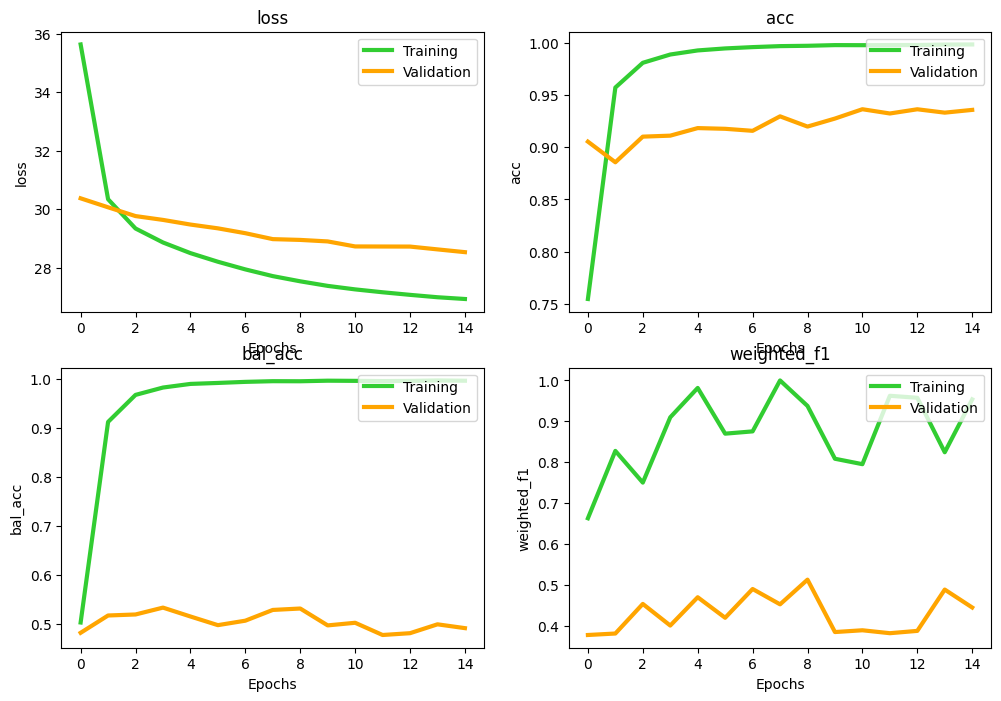

In [40]:
model.save_weights(CONST['SAVED_MODEL'])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for metric, ax in zip(['loss', 'acc', 'bal_acc', 'weighted_f1'], [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]):

  ax.plot(history.history[metric],linewidth=3,color='limegreen')
  ax.plot(history.history[f'val_{metric}'],linewidth=3,color='orange')
  ax.set_title(metric)
  ax.set_xlabel('Epochs')
  ax.set_ylabel(metric)
  ax.legend()
  ax.legend(["Training", "Validation"], loc ="upper right")


## Test

In [41]:
# #simulate predictions

# size=3849
# sentences_ss, tags_ss, tokens_ss, token_ids_ss, token_type_ids_ss, attention_mask_ss, token_tag_ids_ss  = test_sentences[:size], test_tags[:size], tokens_te[:size], token_ids_te[:size], token_type_ids_te[:size], attention_mask_te[:size], token_tag_ids_te[:size]

# p = 0.6 #probably of correct output
# randarr = np.random.rand(size, 128)
# pred_ss = np.zeros(shape=(size, 128), dtype=int)
# cnt = 0

# before = []
# after = []

# for i in range(size):
#   for j in range(128):
#     if attention_mask_ss[i][j]:
#       if(randarr[i][j] <= p):
#         pred_ss[i][j] = token_tag_ids_ss[i][j] #true prediction
#       else:
#         cnt += 1
#         pred_ss[i][j] = np.random.randint(0, n_tags) #wrong prediction
#         before.append(token_tag_ids_ss[i][j])
#         after.append(pred_ss[i][j])

# #adjust predictions
# y_actual_flat = berthelper.getwordlabels(tags_ss)
# y_pred_flat, debug = berthelper.getwordlevelpredictions(sentences_ss, tokens_ss, attention_mask_ss, pred_ss)

# y_actual_disp = []
# print(len(y_actual_flat), len(y_pred_flat))
# debug

In [42]:
# dummy_sentence = [['foooooooxxxxxxxxx', 'baaaaaaaarrrrrrrr', 'zoo', 'hal']]
# tags_dummy = [['B-person', 'I-person', 'O', 'B-movie']]
# tokens_dummy= [['fooo', '##ooo', '##o', '##xxx', '##xxx', '##xxx', 'baaa', '##aaa', '##aa', '##rrr', '##rrr', '##rr', 'zo', '##o', 'hal', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']]
# attention_mask_dummy = [[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0]]
# pred_dummy = [[7, 7, 9, 0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 5, 0, 0, 0, 0, 0]]

# y_actual_dummy = berthelper.getwordlabels(tags_dummy)
# y_pred_dummy, debug = berthelper.getwordlevelpredictions(dummy_sentence, tokens_dummy, attention_mask_dummy, pred_dummy)

# y_actual_dummy, y_pred_dummy

## Model prediction

In [43]:
#prediction against training data
pred_tr = model.predict([token_ids_tr, token_type_ids_tr, attention_mask_tr]).argmax(axis=2)
y_actual_tr = berthelper.getwordlabels(train_tags)
y_pred_tr, debug = berthelper.getwordpredictions(word_token_cnt_tr, pred_tr)

#prediction against dev data
pred_dv = model.predict([token_ids_dv, token_type_ids_dv, attention_mask_dv]).argmax(axis=2)
y_actual_dv = berthelper.getwordlabels(dev_tags)
y_pred_dv, debug = berthelper.getwordpredictions(word_token_cnt_dv, pred_dv)

#prediction against test data
pred_te = model.predict([token_ids_te, token_type_ids_te, attention_mask_te]).argmax(axis=2)
y_actual_te = berthelper.getwordlabels(test_tags)
y_pred_te, debug = berthelper.getwordpredictions(word_token_cnt_te, pred_te)

57/57 [==============================] - 15s 268ms/step


## Model evaluation

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from seqeval.metrics import f1_score as seq_eval_f1_score

def plot_confusion_matrix(y_actual, y_pred):

  accuracy = np.sum(np.array(y_actual) == np.array(y_pred)) / len(y_actual)
  print(f'Accuracy: {accuracy}')

  cm = confusion_matrix(y_actual, y_pred, labels=tags)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
  disp.plot()
  fig = disp.figure_
  fig.set_figwidth(15)
  fig.set_figheight(8)
  fig.suptitle('Plot of confusion matrix')
  disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=90, ha='right')
  plt.show()

def evaluation_scores(y_actual, y_pred, tags):
  BI_tags = np.array(tags)
  BI_tags = list(BI_tags[BI_tags != 'O']) #without O tag

  class_scores = []
  zer_div = 0
  rounding_scale = 2

  mcm = multilabel_confusion_matrix(y_actual, y_pred, labels=tags)
  seqeval_f1 = seq_eval_f1_score([list(y_actual)], [list(y_pred)])

  for i in range(mcm.shape[0]):
    cm = mcm[i]
    TN, TP = cm[0][0], cm[1][1]
    FN, FP = cm[1][0], cm[0][1]
    P = TP + FN #actual positives
    N = TN + FP #actual negatives
    PP = TP + FP #predicted positives
    PN = TN + FN #predicted negatives

    #accuracy = np.round((TP + TN) / (P + N), rounding_scale)
    precision = np.round(TP / PP, rounding_scale) if (PP > 0) else 0
    recall = np.round(TP / P, rounding_scale)
    f1 = np.round(2*precision*recall / (precision + recall), rounding_scale) if ((precision + recall) > 0) else 0

    class_scores.append([tags[i], np.round(P), np.round(TP), np.round(FP), np.round(FN), precision, recall, f1])


  overall_scores = []

  overall_scores.append(['-', 'accuracy', 'all (BIO)', np.round(accuracy_score(y_actual, y_pred), rounding_scale)])
  overall_scores.append(['-', 'bal-acc (macro recall)', 'all (BIO)', np.round(recall_score(y_actual, y_pred, average='macro', labels=tags), rounding_scale)])
  overall_scores.append(['-', 'seqeval f1_score', 'all (BIO)', np.round(seqeval_f1, rounding_scale)])

  for metric, fn in [('precision', precision_score), ('recall', recall_score), ('f1', f1_score)]:
    overall_scores.append(['weighted', metric, 'all (BIO)', np.round(fn(y_actual, y_pred, average='weighted',  labels=tags, zero_division=zer_div), rounding_scale )])

  for metric, fn in [('precision', precision_score), ('recall', recall_score), ('f1', f1_score)]:
    overall_scores.append(['weighted', metric, 'only BI', np.round(fn(y_actual, y_pred, average='weighted',  labels=BI_tags, zero_division=zer_div), rounding_scale)])

  class_scores_df = pd.DataFrame(data=class_scores, columns=['tag', 'actual', 'TP', 'FP', 'FN', 'precision', 'recall', 'f1']).set_index('tag')
  overall_scores_df = pd.DataFrame(data = overall_scores, columns = ['average', 'metric', 'tags', 'score']).set_index(['average', 'metric', 'tags'])

  return class_scores_df, overall_scores_df


### High level evaluation

In [45]:
#train
class_scores_df_tr, overall_scores_df_tr = evaluation_scores(y_actual_tr, y_pred_tr, tags)

#dev
class_scores_df_dv, overall_scores_df_dv = evaluation_scores(y_actual_dv, y_pred_dv, tags)

#test
class_scores_df_te, overall_scores_df_te = evaluation_scores(y_actual_te, y_pred_te, tags)

In [46]:
summarydf = pd.concat([overall_scores_df_tr, overall_scores_df_dv, overall_scores_df_te], axis=1)
summarydf.columns = ['training', 'dev', 'test']
summarydf

training   dev  test
average  metric                 tags                           
-        accuracy               all (BIO)       1.0  0.95  0.95
         bal-acc (macro recall) all (BIO)       1.0  0.52  0.51
         seqeval f1_score       all (BIO)       1.0  0.55  0.55
weighted precision              all (BIO)       1.0  0.95  0.95
         recall                 all (BIO)       1.0  0.95  0.95
         f1                     all (BIO)       1.0  0.95  0.95
         precision              only BI         1.0  0.59  0.57
         recall                 only BI         1.0  0.60  0.60
         f1                     only BI         1.0  0.58  0.57

## Test set evaluation

Accuracy: 0.9477027244881508


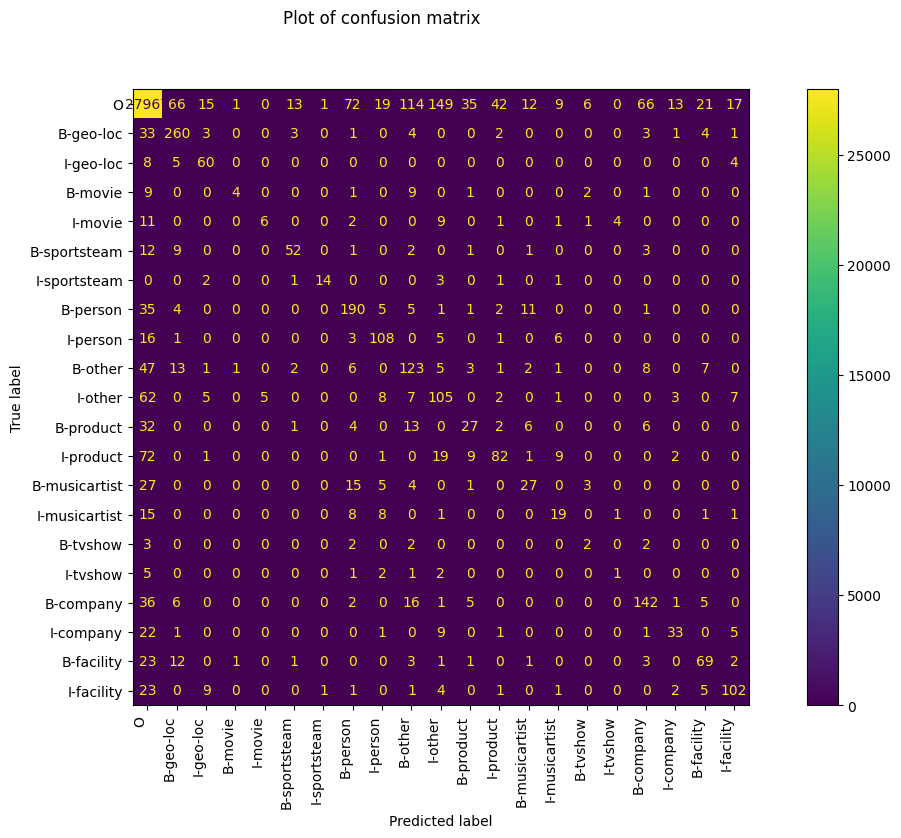

In [47]:
plot_confusion_matrix(y_actual_te, y_pred_te)

In [48]:
class_scores_df_te

,actual,TP,FP,FN,precision,recall,f1
tag,,,,,,,
O,28638,27967,491,671,0.98,0.98,0.98
B-geo-loc,315,260,117,55,0.69,0.83,0.75
I-geo-loc,77,60,36,17,0.62,0.78,0.69
B-movie,27,4,3,23,0.57,0.15,0.24
I-movie,35,6,5,29,0.55,0.17,0.26
B-sportsteam,81,52,21,29,0.71,0.64,0.67
I-sportsteam,22,14,2,8,0.88,0.64,0.74
B-person,255,190,119,65,0.61,0.75,0.67
I-person,140,108,49,32,0.69,0.77,0.73


## mlflow logging

In [49]:
#start mlflow experiement
mlflow.set_experiment(experiment_id = crf_exp_id)
try:
  mlflow.start_run(experiment_id=crf_exp_id)
except: pass
mlfl = mlflow_logger(mlflow)

In [50]:
#log data and train params
mlfl.log_obj(DATA_PARAMS)
mlfl.log_obj(TRAIN_PARAMS)

#log training and validation metrics
mlfl.log_metric('loss', history.history['loss'][-1])
mlfl.log_metric('val_loss', history.history['val_loss'][-1])

#log classification metrics
mlfl.log_df_metrics(overall_scores_df_te)

In [51]:
#view experiments so far
# results = mlflow.search_runs(experiment_ids=crf_exp_id)

# cols_to_ignore = ['params.alphas']
# results = results.drop(columns=cols_to_ignore)
# param_cols = results.columns[results.columns.str.startswith('metric') | results.columns.str.startswith('param')]
# results[param_cols].sort_values(by='metrics.f1-without-o', ascending=False).head(10).T

In [52]:
#end the experiment
mlflow.end_run()

# Notification Alert sound

In [53]:
from IPython.display import Audio
wave = np.sin(2*np.pi*200*np.arange(1000*1)/10000)
Audio(wave, rate=10000, autoplay=True)